## Import Libraries

In [64]:
import numpy as np
import random
import operator 
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


from IPython.display import clear_output

## Create classes and functions

Create class to handle "cities". The input parameters are:
- x coordinate
- y coordinate

Several distances are implemented

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def distance_manhattan(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = xDis + yDis
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

# ---------------------------------------------------------------------- #
#city1 = City(2,3)
#city2 = City(5,1)
#print('The distance between city1 and city2 is: ' + str(city1.distance(city2)))

Create a fitness function. The input is list of the route and the fitness is define as the inverse of the total path.

Input:
- route = individual (list of cities)

Output:
- routeDistance = length of the route
- routeFitness = 1/length of the route

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0
    
    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

# ---------------------------------------------------------------------- #
#city1 = City(2,6)
#city2 = City(5,1)
#canc = Fitness(createRoute([city1, city2]))
#print('Fitness = ', canc.routeFitness())
#print('Distance = ', canc.routeDistance())

## Create our initial population

Route generator. This function 'createRoute' accepts a list of cities and randomize it.

Input:
- list of cities = [(city1, city2, city3)]

Output:
- list of cities = [(city2, city3, city1)]

In [4]:
def createRoute(cityList):
    #route = cityList
    route = random.sample(cityList, len(cityList))
    return route

# ---------------------------------------------------------------------- #
#city1 = City(2,6)
#city2 = City(5,1)
#city3 = City(2,3)
#city4 = City(8,7)
#createRoute([city1, city2, city3, city4])

Create first "population" (list of routes)

Input:
- popSize = # of individuals
- cityList = list of cities

Output:
- list of n (individuals) lists 

In [5]:
def initialPopulation(popSize, cityList):
    population = [createRoute(cityList) for i in range(0,popSize)]
    return population

# ---------------------------------------------------------------------- #
#city1 = City(2,6)
#city2 = City(5,1)
#city3 = City(2,3)
#city4 = City(8,7)
#initialPopulation(3,[city1, city2, city3, city4])

## Create the genetic algorithm

Rank individuals. It returns a list of m (m = PopSize) tuples with the individual index and the fitness value. The list is ordered by fitness.

Input:
- populations = list of individuals

Output:
- [(index_individual, fitness),(index_individual, fitness),(index_individual, fitness),...,(index_individual, fitness)]

In [6]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

# ---------------------------------------------------------------------- #
#city1 = City(2,6)
#city2 = City(5,1)
#city3 = City(2,3)
#city4 = City(8,7)
#pop = initialPopulation(3,[city1, city2, city3, city4])
#rankRoutes(pop)

Create a selection function that will be used to make the list of parent routes.

Input:
- popRanked: list of tuples (2 values) with the index and the the fitness value
- eliteSize: # of parents to include by default

Output:
- list of individuals indexes

In [7]:
def selection(popRanked, eliteSize):
    selectionResults = []
    # convert the list of tuples into a dataframe labeling the 2 columns
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    
    # add 2 columns: cumulative sum and normalized cumulative sum (roulette)
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    # save the first n (n = eliteSize) indexes. Best performers are selected as parents!
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    
    # roulette
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

# ---------------------------------------------------------------------- #
#city1 = City(2,6)
#city2 = City(5,1)
#city3 = City(2,3)
#city4 = City(8,7)
#pop = initialPopulation(8,[city1, city2, city3, city4])
#rank = rankRoutes(pop)
#selRes = selection(rank, 4)
#print(rank)
#print('populat:',[rank[i][0] for i in range(len(rank))])
#print('parents:', selRes)

Create mating pool. Mating pool is the parents population. 

Input:
- population
- selectionResults

Output:
- matingpool

In [8]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

# ---------------------------------------------------------------------- #
#city1 = City(2,6)
#city2 = City(5,1)
#city3 = City(2,3)
#city4 = City(8,7)
#pop = initialPopulation(8,[city1, city2, city3, city4])
#rank = rankRoutes(pop)
#selRes = selection(rank, 4)
#matingPool(pop, selRes)

Create a crossover function for two parents to create one child.

Input:
- parent1 = individual 1
- parent2 = individual 2

Output:
- child = new individual

In [9]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

# ---------------------------------------------------------------------- #
#city1 = City(2,6)
#city2 = City(5,1)
#city3 = City(2,3)
#city4 = City(8,7)
#pop = initialPopulation(8,[city1, city2, city3, city4])
#breed(pop[1],pop[2])

Create function to run crossover over full mating pool.

Input:
- matingpool = 
- eliteSize = 

Output:
- children = 

In [10]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)

    return children

Create function to mutate a single route. All the individuals can mutate. A mutation is a switch of the cities.

In [11]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            while swapWith==swapped:
                swapWith = int(random.random() * len(individual))

            # switch the 2 cities
            city1 = individual[swapped]
            city2 = individual[swapWith]          
            individual[swapped] = city2
            individual[swapWith] = city1
            
    return individual

Create function to run mutation over entire population

In [12]:
def mutatePopulation(population, mutationRate):
    mutatedPop = [mutate(population[ind], mutationRate) for ind in range(0, len(population))]
    return mutatedPop

Put all steps together to create the next generation

In [13]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    
    popRanked = rankRoutes(currentGen)
    #print('a:', popRanked)
    selectionResults = selection(popRanked, eliteSize)
    #print('b:', selectionResults)
    matingpool = matingPool(currentGen, selectionResults)
    #print('c', matingpool)
    children = breedPopulation(matingpool, eliteSize)
    #print('d', children)
    nextGeneration = mutatePopulation(children, mutationRate)
    #print('e', nextGeneration)
    return nextGeneration

Final step: create the genetic algorithm

In [146]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    training = []
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    fig = plt.figure(figsize=(15,4))
    #plt.figure()
    ax = fig.add_subplot(1,2,1)
    ay = fig.add_subplot(1,2,2)
    

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        training.append(1 / rankRoutes(pop)[0][1])
    
        #output during the training
        if i%10 == 0:
            #clear_output()
            print("Distance " + str(i) + " :" + str(1 / rankRoutes(pop)[0][1]))
            bestRouteIndex = rankRoutes(pop)[0][0]
            bestRoute = np.array(pop[bestRouteIndex])
            a = bestRoute
            x = [a[0].x]
            y = [a[0].y]

            for i in np.arange(len(a)):
                x.append(a[i].x) 
                y.append(a[i].y) 

            ax.cla()
            ax.plot(x,y, '-o')
            
            ay.cla()
            ay.plot(range(len(training)),training)
            
            ax.set_ylabel('Distance')
            ax.set_xlabel('Generation')
            ax.set_xlim([0, 200])
            ax.set_ylim([0, 200])


            ay.set_ylabel('Fitness')
            ay.set_xlabel('Generation')
            ay.set_xlim([0, generations])
            #ay.set_ylim([0, 3000])
            
            display(fig)
            clear_output(wait=True)
            #plt.pause(0.5)        #to be used for .py file
    
        
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = np.array(pop[bestRouteIndex])

    return bestRoute, training

## Running the genetic algorithm

Define input

In [115]:
num_cities = 30
num_generations = 1500
i_popSize = 70
i_eliteSize = 30
i_space = 200
i_mutationRate = 0.01

Create list of cities

In [16]:
cityList = [City(x=int(random.random() * i_space), y=int(random.random() * i_space))for i in range(0,num_cities)]
    
#cityList

Run the genetic algorithm

Final distance: 924.4037529473856


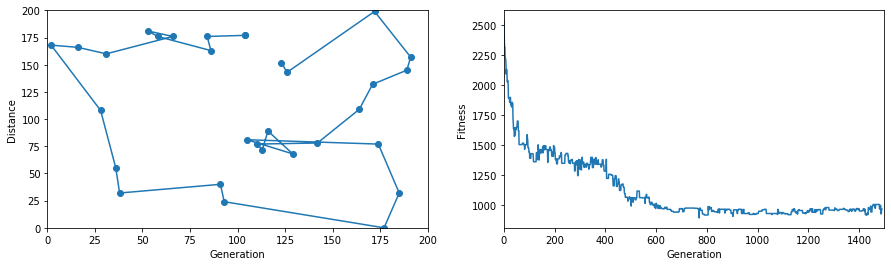

In [147]:
path, progress = geneticAlgorithm(population=cityList, 
                        popSize=i_popSize, 
                        eliteSize=i_eliteSize, 
                        mutationRate=i_mutationRate, 
                        generations=num_generations)

## Plot the progress

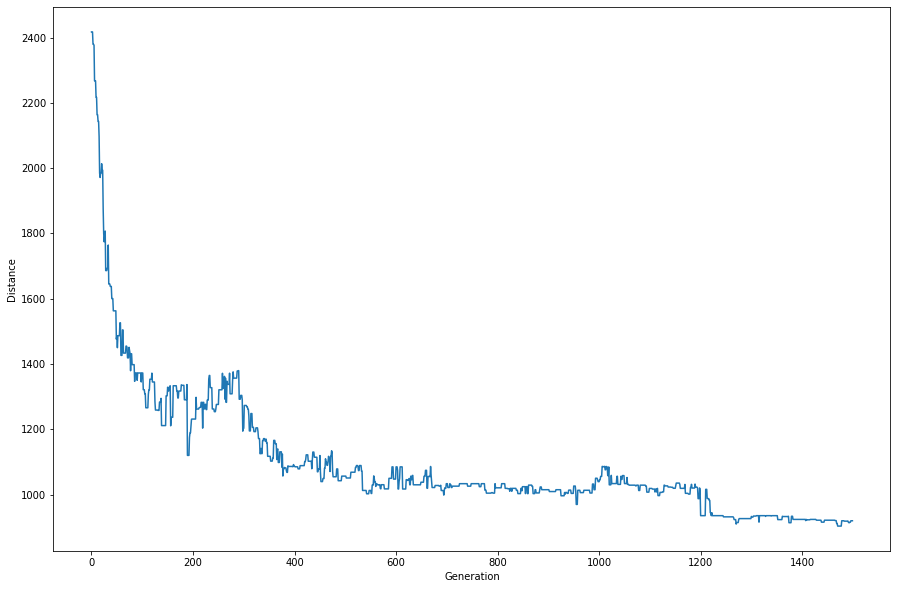

In [143]:
plt.figure(figsize=(15,10))
plt.ylabel('Distance')
plt.xlabel('Generation')
plt.plot(range(len(progress)),progress)

#Note, this will win run a separate GA

In [42]:
#def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
#    pop = initialPopulation(popSize, population)
#    progress = []
#    progress.append(1 / rankRoutes(pop)[0][1])
#    
#    for i in range(0, generations):
#        pop = nextGeneration(pop, eliteSize, mutationRate)
#        progress.append(1 / rankRoutes(pop)[0][1])
#    
#    plt.plot(progress)
#    plt.ylabel('Distance')
#    plt.xlabel('Generation')
#    plt.show()

Run the function with our assumptions to see how distance has improved in each generation

In [43]:
#geneticAlgorithmPlot(population=cityList, 
#                     popSize=i_popSize, 
#                     eliteSize=i_eliteSize, 
#                     mutationRate=0.01, 
#                     generations=num_generations)